In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$

In [3]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i+1)  # gamma(n) = (n-1)!
# labels的维度: (n_train+n_test, )
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [6]:
# ndarray2tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32)
                                          for x in [true_w, features, poly_features, labels]]

In [7]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.0053],
         [ 0.7909]]),
 tensor([[ 1.0000e+00, -1.0053e+00,  5.0535e-01, -1.6935e-01,  4.2564e-02,
          -8.5582e-03,  1.4340e-03, -2.0595e-04,  2.5881e-05, -2.8910e-06,
           2.9064e-07, -2.6563e-08,  2.2254e-09, -1.7210e-10,  1.2359e-11,
          -8.2830e-13,  5.2045e-14, -3.0778e-15,  1.7190e-16, -9.0959e-18],
         [ 1.0000e+00,  7.9091e-01,  3.1277e-01,  8.2457e-02,  1.6304e-02,
           2.5790e-03,  3.3996e-04,  3.8411e-05,  3.7975e-06,  3.3372e-07,
           2.6394e-08,  1.8978e-09,  1.2508e-10,  7.6097e-12,  4.2990e-13,
           2.2668e-14,  1.1205e-15,  5.2130e-17,  2.2906e-18,  9.5349e-20]]),
 tensor([1.1098, 5.5071]))

In [8]:
def evaluate_loss(net, data_iter, loss):
    # @save
    '''评估给定数据集上模型的损失'''
    metric = d2l.Accumulator(2)  # 损失的总和，样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [13]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1,num_epochs], ylim=[1e-3,1e2], legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch==0 or (epoch+1)%20==0:
            animator.add(epoch+1, (evaluate_loss(net,train_iter,loss), evaluate_loss(net,test_iter,loss)))
    print('weight:', net[0].weight.data.numpy())

### 三阶多项式函数拟合（正常）

weight: [[ 5.0108953  1.209014  -3.4241354  5.5807457]]


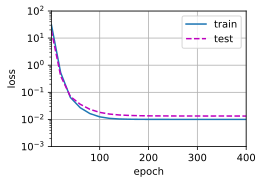

In [14]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
     labels[:n_train], labels[n_train:])

### 线性函数拟合（欠拟合）

weight: [[2.9697726 5.285432 ]]


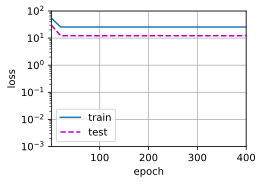

In [15]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:])

### 高阶多项式函数拟合（过拟合）

weight: [[ 4.9676809e+00  1.4024657e+00 -3.1952288e+00  5.0540581e+00
  -6.4278603e-01  4.6691272e-01  3.0698672e-01 -4.0835187e-02
   1.8252814e-01  7.4884325e-02  4.0746026e-02  1.6529873e-01
  -8.6917952e-02  9.7257555e-02 -1.6889413e-01 -2.2029479e-01
   3.9629593e-02  1.8072380e-03 -2.0401973e-01  1.9672814e-01]]


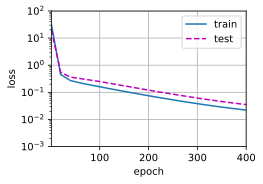

In [16]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
     labels[:n_train], labels[n_train:])